# Face Detection and Recognition

#### Using VGGFace and MTCNN

## By Brea Koenes

The `data` directory contains three folders 30 face images of three players from the 2024 Philadelphia Phillies: Alec Bohm, Bryson Stott, and Brandon Marsh. The original images were downloaded from Google Images and the face images were extraced using a `extract_faces` function. In addition, the `Samples` directory contains three images of a combination of those players.

Below, I create a system that can correctly detect and identify Bohm, Stott, and Marsh in those three sample images.

### Imports

In [68]:
# Imports
import subprocess
import sys
from IPython.display import clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mtcnn.mtcnn import MTCNN
import os
from tensorflow.keras.preprocessing import image
%matplotlib inline

def check_tensorflow():
    tf_desired_version = "2.9.2"

    try:
        import tensorflow as tf
        tf_installed_version = tf.__version__
    except ImportError:
        tf_installed_version = None

    #Check for the right version
    if tf_installed_version != tf_desired_version:
        print(f"Current TensorFlow version: {tf_installed_version}. Installing version {tf_desired_version}...")
        
        # Uninstall the current TensorFlow version
        subprocess.check_call([sys.executable, '-m', 'pip', 'uninstall', '-y', 'tensorflow'])
        
        # Install the desired TensorFlow version
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', f'tensorflow=={tf_desired_version}'])

        clear_output()
        
        print(f"TensorFlow version {tf_desired_version} installed successfully. Please restart your kernel to apply the changes.")
    else:
        print(f"TensorFlow version {tf_desired_version} is already installed.")    

check_tensorflow()

TensorFlow version 2.9.2 is already installed.


In [69]:
# Define helper functions
def load_images_from_path(path, label):
    images, labels = [], []
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        if os.path.isfile(file_path):  # Ignore directories
            try:
                img = image.load_img(file_path, target_size=(224, 224, 3))
                images.append(image.img_to_array(img))
                labels.append(label)
            except Exception as e:
                print(f"Skipping {file}: {e}")  # Handle non-image files
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, min(10, len(images)), figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

# Declare lists to hold images and labels
x, y = [], []

### Load and label images

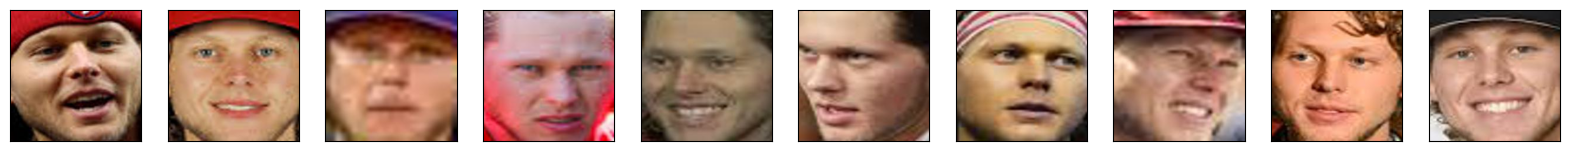

In [70]:
# Load Bohm images, label with 0s
images, labels = load_images_from_path('data/Bohm', 0)
show_images(images)

x += images
y += labels

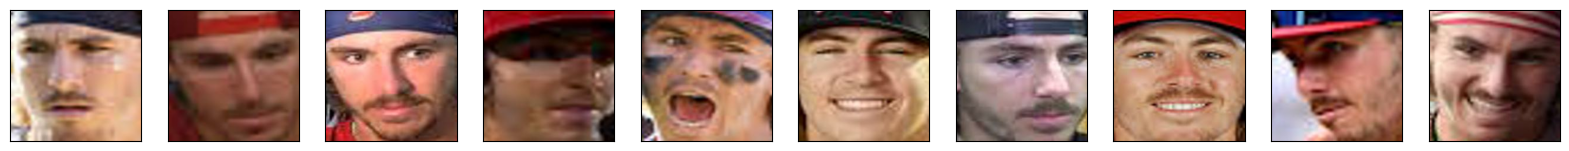

In [71]:
# Load Stott images, label with 1s
images, labels = load_images_from_path('data/Stott', 1)
show_images(images)

x += images
y += labels

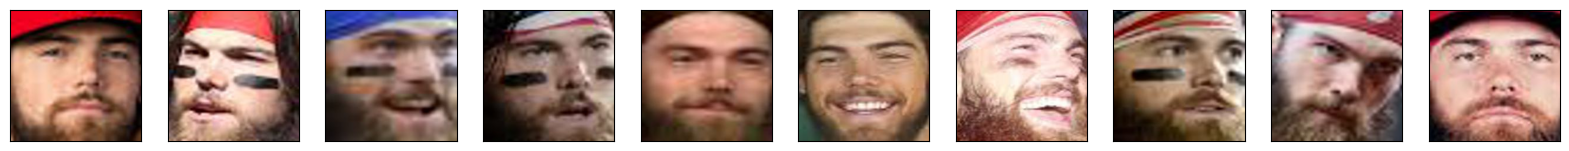

In [72]:
# Load Marsh images, label with 2s
images, labels = load_images_from_path('data/Marsh', 2)
show_images(images)

x += images
y += labels

### Prepare for VGGFace

In [73]:
# Preprocess pixels for VGGFace
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input

faces = preprocess_input(np.array(x))
labels = np.array(y)

# Split data into 50/50 into training/testing
# Trained w 5 random images of ea person, and validated w the same number of images
x_train, x_test, y_train, y_test = train_test_split(faces, labels, train_size=0.5, stratify=labels, random_state=0)

In [74]:
# Load vggface model, freeze model
from tensorflow.keras.models import load_model

base_model = load_model('Data/vggface.h5')
base_model.trainable = False

### Create and train model

In [75]:
# Add classification layers and resize layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import Flatten, Dense

model = Sequential()
model.add(Resizing(224,224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(16, activation='relu')) # changed from 8
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=10) # batch size changed from 20

Epoch 1/10
2/2 [==============================] - 2s 828ms/step - loss: 0.8728 - accuracy: 0.7333 - val_loss: 0.5229 - val_accuracy: 0.7333
Epoch 2/10
2/2 [==============================] - 1s 471ms/step - loss: 0.0187 - accuracy: 1.0000 - val_loss: 0.1460 - val_accuracy: 0.9333
Epoch 3/10
2/2 [==============================] - 1s 485ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.1249 - val_accuracy: 0.9333
Epoch 4/10
2/2 [==============================] - 1s 491ms/step - loss: 2.6930e-04 - accuracy: 1.0000 - val_loss: 0.1333 - val_accuracy: 0.9333
Epoch 5/10
2/2 [==============================] - 1s 471ms/step - loss: 6.4666e-05 - accuracy: 1.0000 - val_loss: 0.1414 - val_accuracy: 0.9333
Epoch 6/10
2/2 [==============================] - 1s 461ms/step - loss: 4.0917e-05 - accuracy: 1.0000 - val_loss: 0.1482 - val_accuracy: 0.9333
Epoch 7/10
2/2 [==============================] - 1s 459ms/step - loss: 2.2839e-05 - accuracy: 1.0000 - val_loss: 0.1539 - val_accuracy: 0.9333
Epoc

[]

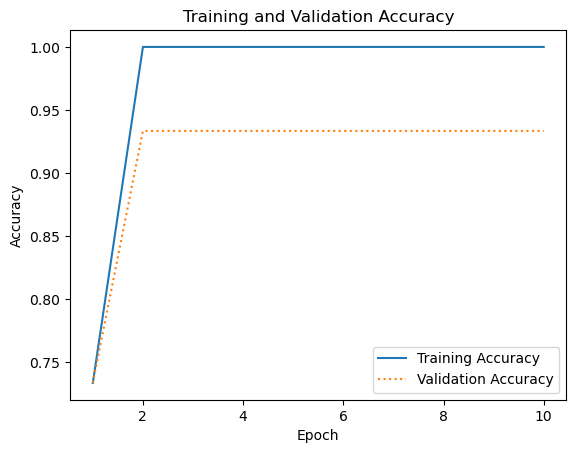

In [76]:
# Plot accuracy
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

### Multi-Task Cascaded Convolutional Networks to detect faces

In [77]:
# Now that it's trained, focus on mtcnn

# Define 2 helper functions
from mtcnn.mtcnn import MTCNN
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing import image
from matplotlib.patches import Rectangle

# Gets faces from specific location in the image
def get_face(image, face):
    x1, y1, w, h = face['box']
    
    if w > h:
        x1 = x1 + ((w - h) // 2)
        w = h
    elif h > w:
        y1 = y1 + ((h - w) // 2)
        h = w
        
    x2 = x1 + h
    y2 = y1 + w
    
    return image[y1:y2, x1:x2]

# Load photo and annotate face in photo w/ name and conf level
def label_faces(path, model, names, face_threshold=0.9, prediction_threshold=0.9, show_outline=True, size=(12, 8)):
    # Load the image and orient it correctly
    pil_image = Image.open(path)
    exif = pil_image.getexif()
    
    for k in exif.keys():
        if k != 0x0112:
            exif[k] = None
            del exif[k]
            
    pil_image.info["exif"] = exif.tobytes()
    pil_image = ImageOps.exif_transpose(pil_image)
    np_image = np.array(pil_image)

    fig, ax = plt.subplots(figsize=size, subplot_kw={'xticks': [], 'yticks': []})
    ax.imshow(np_image)

    detector = MTCNN()
    faces = detector.detect_faces(np_image)
    faces = [face for face in faces if face['confidence'] > face_threshold]

    for face in faces:
        x, y, w, h = face['box']

        # Use the model to identify the face
        face_image = get_face(np_image, face)
        face_image = image.array_to_img(face_image)
        face_image = preprocess_input(np.array(face_image))
        predictions = model.predict(np.expand_dims(face_image, axis=0))
        confidence = np.max(predictions)

        if (confidence > prediction_threshold):
        # Optionally draw a box around the face
            if show_outline:
                rect = Rectangle((x, y), w, h, color='red', fill=False, lw=2)
                ax.add_patch(rect)

            # Label the face
            index = int(np.argmax(predictions))
            text = f'{names[index]} ({confidence:.1%})'
            ax.text(x + (w / 2), y, text, color='white', backgroundcolor='red', ha='center', va='bottom', fontweight='bold', bbox=dict(color='red'))

1/1 [==============================] - 0s 264ms/step


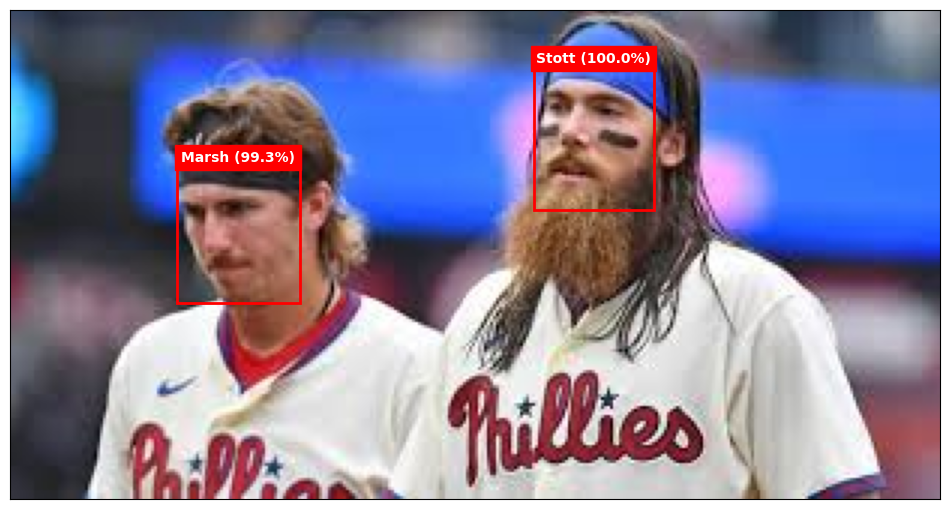

In [78]:
# Pass labels to function on first image to see how model does
labels = ['Bohm', 'Marsh', 'Stott']
label_faces('data//Samples/sample-1.jpeg', model, labels)

1/1 [==============================] - 0s 39ms/step


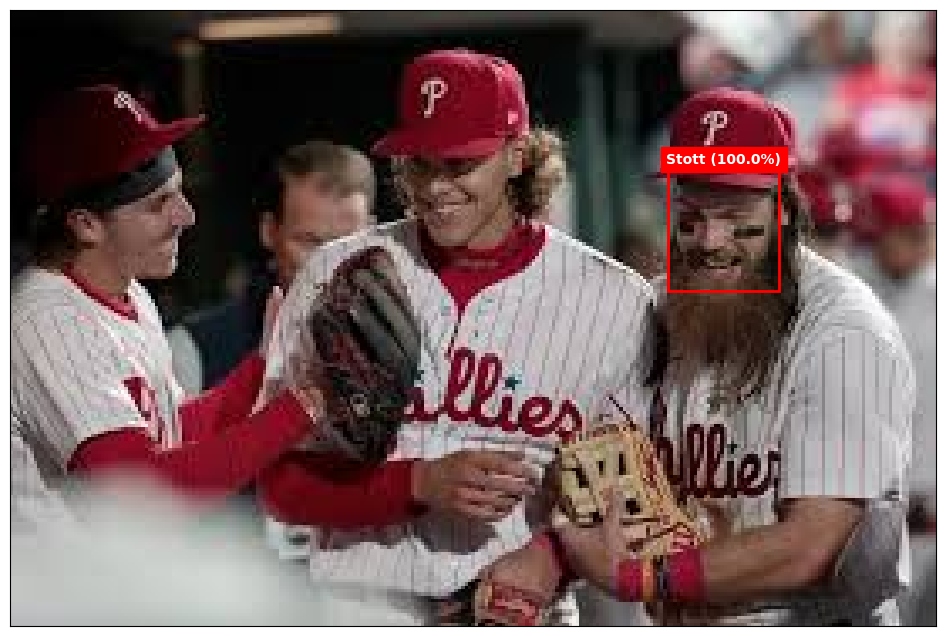

In [79]:
# Pass labels to function on first image to see how model does
labels = ['Bohm', 'Marsh', 'Stott']
label_faces('data//Samples/sample-2.jpeg', model, labels)

1/1 [==============================] - 0s 37ms/step


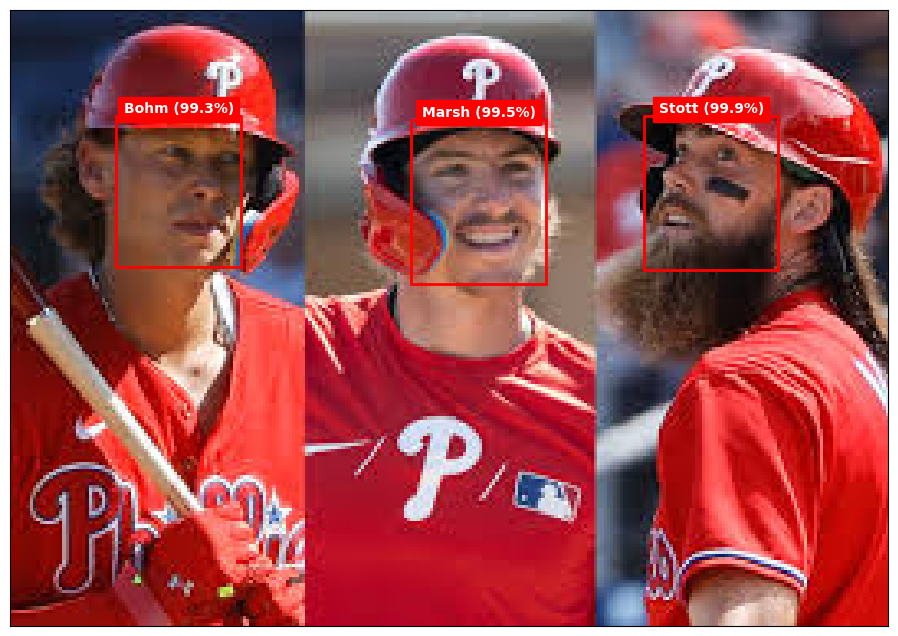

In [80]:
# Pass labels to function on first image to see how model does
labels = ['Bohm', 'Marsh', 'Stott']
label_faces('data//Samples/sample-3.jpeg', model, labels)

### Further evaluate model

In [81]:
# Functions below are used to further evaluate the model
import os
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from PIL import Image, ImageOps
from mtcnn.mtcnn import MTCNN
from tensorflow.keras.applications.resnet50 import preprocess_input


def make_pred(path, model, names, face_threshold=0.9, prediction_threshold=0.9, show_outline=True, size=(12, 8)):
    # Load the image and orient it correctly
    pil_image = Image.open(path)
    exif = pil_image.getexif()
    
    for k in exif.keys():
        if k != 0x0112:
            exif[k] = None
            del exif[k]
            
    pil_image.info["exif"] = exif.tobytes()
    pil_image = ImageOps.exif_transpose(pil_image)
    np_image = np.array(pil_image)

    detector = MTCNN()
    faces = detector.detect_faces(np_image)
    faces = [face for face in faces if face['confidence'] > face_threshold]

    for face in faces:
        x, y, w, h = face['box']

        # Use the model to identify the face
        face_image = get_face(np_image, face)
        face_image = image.array_to_img(face_image)
        face_image = preprocess_input(np.array(face_image))
        predictions = model.predict(np.expand_dims(face_image, axis=0))
        confidence = np.max(predictions)

        if (confidence > prediction_threshold):
            return predictions
            

        return None
        
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

def get_all_images_from_directory(directory):
    images = []
    labels = []
    images_names = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            images_names += [img for img in os.listdir(label_path)]
            images += [os.path.join(label_path, img) for img in os.listdir(label_path)]
            labels += [int(label)] * len(os.listdir(label_path))
    
    # Embaralhar as imagens e labels
    combined = list(zip(images_names, images, labels))
    random.shuffle(combined)
    images_names, images, labels = zip(*combined)
    
    # Return images_names, images, labels
    return zip(*combined)

def predict_and_validate(model, image_names, image_paths, true_labels, class_labels):
    predictions = []
    for img_path in image_paths:
        predictions.append(make_pred(img_path, model, class_labels, prediction_threshold=0.8))
    
    results = [true == pred for true, pred in zip(true_labels, predictions)]
    
    df = pd.DataFrame({
        'Player': image_names,
        'Prediction Array': predictions
    })
    
    return df

In [82]:
# Create prediction array
from IPython.display import clear_output

model_to_evaluate = model  

class_labels = {0: 'Alec Bohm', 1: 'Bryson Stott', 2: 'Brandon Marsh'} 
image_names, image_paths, true_labels = get_all_images_from_directory('data/codegrade_test/')
prediction_df = predict_and_validate(model_to_evaluate, image_names, image_paths, true_labels, class_labels)
clear_output()
prediction_df

,Player,Prediction Array
0,Bryson_09.png,"[[1.0782675e-08, 0.9997677, 0.00023225283]]"
1,Bryson_04.png,"[[2.792527e-08, 0.9998952, 0.0001047982]]"
2,alec_01.jpg,"[[1.0, 9.496467e-14, 2.5922608e-14]]"
3,Brandon_04.png,"[[4.597882e-09, 8.3411585e-08, 0.9999999]]"
4,alec_02.jpg,"[[1.0, 1.8429285e-13, 3.9907032e-13]]"
5,Brandon_07.png,"[[7.5341395e-06, 5.414812e-05, 0.99993837]]"
6,alec_06.jpg,"[[1.0, 8.740612e-15, 1.6186897e-15]]"
7,Brandon_03.png,"[[0.044781882, 7.100047e-05, 0.9551471]]"
8,Bryson_06.png,"[[1.6545252e-08, 0.9999857, 1.4360946e-05]]"
9,alec_05.jpg,"[[1.0, 2.8550737e-10, 1.3375585e-11]]"


In [83]:
import pandas as pd

# Export classification model 
prediction_df.to_pickle('prediction_df')